In [ ]:
#Importo il modulo drive, fornito da Colab, per interagire con Google Drive.
from google.colab import drive
#Monta il mio Google Drive nella directory locale /content/drive del runtime, con la garanzia che sia in uno stato "pulito".
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
global_var = {
    # PARAMETRI DI CARICAMENTO / PREPROCESSING DEI DATI:
    "batch_size": 64,     #Numero di campioni elaborati in un singolo batch.
    "n_workers": 2,       #Processi del DataLoader che pre-caricano i dati in parallelo.
    "max_seq_len": 1024,  #Lunghezza massima (token): i testi più lunghi verranno troncati.
                          #Quelli più corti verranno riempiti con il token <pad>.

    # PARAMETRI DEL MODELLO:
    "embedding_dim": 128,   #Dimensione dei vettori di embedding (spazio semantico dei token).
    "hidden_dim": 128,      #Neuroni del layer nascosto dell’MLP.
    "output_dim": 2,        #Dimensione dell’output: 2 classi --> 0 = Human , 1 = GenAI.

    # PARAMETRI DI TRAINING:
    "learning_rate": 1e-3,    #Tasso di apprendimento dell’ottimizzatore (es. Adam).
    "epochs": 10,             #Numero di epoche: quante volte l’intero dataset viene visto dal modello.

    # PARAMETRI DI VALIDAZIONE/REGOLARIZZAZIONE:
    "val_size": 0.2,            #Frazione di split per validazione (hold-out del 20%).
    "dropout": 0.3,             #Probabilità di spegnimento neuroni a train-time (keep probability q=0.7).
    "weight_decay": 1e-4,       #Penalità L2 per controllare l'overfitting.
    "label_smoothing": 0.05,    #Smoothing del target (per K=2: [0.95, 0.05] sul vettore obiettivo).
    "patience": 4               #Early stopping se la val-loss non migliora per 4 epoche consecutive.
}

In [ ]:
# STANDARD LIBRARY (Python):
import os                        #Gestione percorsi, variabili d'ambiente, I/O di base.
import math                      #Funzioni matematiche (p.es. ceil, log, sqrt).
import copy                      #Copie profonde/superficiali di oggetti complessi (es. pesi modello).
import re                        #Espressioni regolari per pulizia e parsing dei testi.
import random                    #RNG standard (per seed e sampling semplice).
from collections import Counter  #Conteggi frequenze di token/etichette.

# CALCOLO NUMERICO / DATI TABELLARI:
import numpy as np               #Tensori/array N-dim, operazioni numeriche vettorizzate.
import pandas as pd              #Tabelle, CSV/Parquet, join/filter/groupby.

# VISUALIZZAZIONE:
import matplotlib.pyplot as plt  #Grafici 2D (linee, barre, scatter, heatmap via imshow).
import seaborn as sns            #Wrapper statistico su Matplotlib (stile + funzioni comode).

# PROGRESS BAR (notebook-friendly):
from tqdm.notebook import tqdm   #Barra di avanzamento per loop su batch/epoche.

# PyTorch (core + dataset + mixed precision):
import torch                                              #Tensori e operazioni su CPU/GPU; gestione device.
import torch.nn as nn                                     #Moduli di rete (Linear, Dropout, ReLU, etc).
import torch.nn.functional as F                           #Funzioni funzionali (relu, cross_entropy, log_softmax, etc).
from torch.utils.data import Dataset, DataLoader, Subset  #API per dataset custom e mini-batch.
from torch.cuda import amp                                #Per AMP.
from torch.cuda.amp import autocast, GradScaler           #AMP: mixed precision e scaler.

# Scikit-learn (split + metriche):
from sklearn.model_selection import train_test_split      #Split train/val/test stratificato.
from sklearn.metrics import (
    accuracy_score,                                       #Accuratezza: (TP+TN)/totale;
    balanced_accuracy_score,                              #Media delle recall per classe;
    f1_score,                                             #F1 = 2·(precision·recall)/(precision+recall);
    precision_recall_fscore_support,                      #Precision, recall, fscore per classe e macro/micro;
    confusion_matrix,                                     #Matrice di confusione (TP/TN/FP/FN per classe);
    classification_report                                 #Report testuale riassuntivo per classe e aggregati.
)

In [ ]:
#Verifica se l'ambiente corrente ha una GPU NVIDIA disponibile (e PyTorch con build CUDA).
#Se sì, seleziona il primo device GPU ("cuda:0"); altrimenti usa il processore ("cpu").
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Log utile per debug/trasparenza: stampa il device scelto (cpu oppure cuda:0).
print(f"[LOG] Device → {device}")

[LOG] Device → cpu


In [ ]:
def collate_trim(batch):
    """
    Collate function per DataLoader.
    Input: batch = lista di tuple (x, y), con x tensore 1D di token ID (padded con 0) e y etichetta.
    Output: (xs_trim, ys) con xs_trim di shape [B, L_batch] dove L_batch = max lunghezza reale nel batch.
    Assunzione: PAD == 0 e non viene usato come token "valido".
    """
    xs, ys = zip(*batch)  #Unpack: xs = sequenze, ys = etichette; xs è una tupla di tensori 1D [T_max].

    #Lunghezza reale per sequenza: conta i token != 0 (cioè non PAD).
    lens = [int((x != 0).sum().item()) for x in xs]

    #Evita edge case L_batch = 0 se tutte le sequenze sono vuote; garantisce almeno 1.
    maxlen = max(1, max(lens)) if lens else 1

    #Taglia ogni sequenza alla lunghezza massima del batch: riduce compute/memoria.
    xs_trim = torch.stack([x[:maxlen] for x in xs])  # Shape [B, maxlen]

    #Stack delle etichette in un tensore 1D di shape [B]
    ys = torch.stack(ys)

    return xs_trim, ys

def make_loader(dataset, batch_size, shuffle):
    """
    Costruisce un DataLoader "veloce":
      - usa collate_trim per dynamic padding/trimming per-batch;
      - pin_memory su CUDA per velocizzare i transfer CPU→GPU (.to(device, non_blocking=True));
      - se n_workers > 0: worker persistenti + prefetch di più batch.
    """
    kwargs = {}
    if global_var["n_workers"] > 0:
        kwargs["persistent_workers"] = True   #Evita teardown/respawn dei worker ad ogni epoca.
        kwargs["prefetch_factor"] = 4         #Ogni worker pre-carica N batch (default=2); 4 = più aggressivo.

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=global_var["n_workers"],
        pin_memory=(device.type == "cuda"),   #Consigliato su CUDA; innocuo su CPU.
        collate_fn=collate_trim,              #Applica il trimming dinamico definito sopra.
        **kwargs
    )

In [ ]:
# --- HOLDOUT per VALIDATION + TEST fisso dal DEV -----------------------------
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"
os.makedirs(BASE, exist_ok=True)

TRAIN_CSV_ORIG = f"{BASE}/it_train_full.csv"   # train reale
DEV_CSV_ORIG   = f"{BASE}/it_dev_full.csv"     # dev reale

VAL_CSV  = f"{BASE}/it_val_holdout.csv"        # VALIDATION = resto del DEV
TEST_CSV = f"{BASE}/it_test_fixed.csv"         # TEST = 60 righe richieste

# Carica
df_train = pd.read_csv(TRAIN_CSV_ORIG)
df_dev   = pd.read_csv(DEV_CSV_ORIG)
assert "label" in df_train.columns and "label" in df_dev.columns, "Manca 'label' nei CSV."

# Indici dei 60 casi per TEST
TEST_IDS = [15,53,56,63,67,90,180,191,193,200,211,230,287,320,328,409,442,449,453,459,
            478,503,543,565,571,691,698,706,737,780,861,866,867,921,948,1036,1118,1151,
            1208,1211,1234,1238,1311,1332,1387,1431,1438,1468,1496,1510,1518,1520,1555,
            1565,1652,1654,1659,1737,1782,1825]
TEST_IDS = list(dict.fromkeys(TEST_IDS))  # de-dup

def pick_test_rows_from_dev(df_dev, ids):
    """Seleziona le 60 righe dal DEV: prova by 'id', poi per posizione 0-based e 1-based."""
    n_id = -1
    if "id" in df_dev.columns:
        ser_id = df_dev["id"]
        m_id = ser_id.isin(ids)
        if m_id.sum() < len(ids):
            try:
                m_id = m_id | pd.to_numeric(ser_id, errors="coerce").isin(ids)
            except Exception:
                pass
        n_id = int(m_id.sum())
    else:
        m_id = pd.Series(False, index=df_dev.index)

    m_pos0 = df_dev.index.isin(ids);       n_pos0 = int(m_pos0.sum())
    ids_m1 = [i-1 for i in ids]
    m_pos1 = df_dev.index.isin(ids_m1);    n_pos1 = int(m_pos1.sum())

    if n_id >= max(n_pos0, n_pos1):
        sel = df_dev.loc[m_id].copy(); used = sel.index; how = "by id"
    elif n_pos0 >= n_pos1:
        sel = df_dev.loc[m_pos0].copy(); used = sel.index; how = "by 0-based row index"
    else:
        sel = df_dev.loc[m_pos1].copy(); used = sel.index; how = "by 1-based row index (id-1)"
    return sel, used, how

# Selezione test + validazione = resto
df_test_sel, used_test_index, how_used = pick_test_rows_from_dev(df_dev, TEST_IDS)
assert len(df_test_sel) > 0, "Nessuna riga selezionata per il TEST: controlla indici/ID."

# Salva indici originali per anti-leakage, poi reset
df_test = df_test_sel.copy();                   df_test["__orig_idx__"] = used_test_index
df_val  = df_dev.drop(index=used_test_index).copy(); df_val["__orig_idx__"] = df_val.index

# Sanity su indici originali, poi pulizia colonne helper
assert set(df_test["__orig_idx__"]).isdisjoint(set(df_val["__orig_idx__"])), "Leakage VAL↔TEST."
assert len(df_test) + len(df_val) == len(df_dev), "VAL+TEST deve coprire tutto il DEV."
df_test = df_test.drop(columns="__orig_idx__").reset_index(drop=True)
df_val  = df_val.drop(columns="__orig_idx__").reset_index(drop=True)

df_val.to_csv(VAL_CSV,  index=False)
df_test.to_csv(TEST_CSV, index=False)

print(f"[LOG] DEV: {len(df_dev)} | TEST: {len(df_test)} | VAL: {len(df_val)}  ({how_used})")
print("[LOG] VAL distribuzione:",  df_val['label'].value_counts().sort_index().to_dict())
print("[LOG] TEST distribuzione:", df_test['label'].value_counts().sort_index().to_dict())

[LOG] DEV: 1843 | TEST: 60 | VAL: 1783  (by 0-based row index)
[LOG] VAL distribuzione: {1: 1783}
[LOG] TEST distribuzione: {1: 60}


In [ ]:
PAD, UNK = "<pad>", "<unk>"                             #Token speciali: <pad> (id 0) e <unk> (id 1) riservati.
_token_re = re.compile(r"\b\w+\b", flags=re.UNICODE)    #Regex Unicode: cattura parole alfanumeriche tra confini di parola.

def basic_tokenizer(text: str):                         #Funzione di tokenizzazione minimal basata su regex.
    return _token_re.findall(text.lower())              #Lowercase + estrazione dei token; punteggiatura rimossa.

def build_vocab(text_iter, min_freq: int = 1):          #Costruisce il vocabolario da un iterabile di righe di testo.
    counter = Counter()                                 #Multinsieme di frequenze dei token.
    for line in text_iter:                              #Passata unica su tutte le righe.
        counter.update(basic_tokenizer(line))           #Aggiunge i token della riga al contatore.
    vocab = {PAD: 0, UNK: 1}                            #Inizializza il mapping con gli ID riservati.
    for tok, c in counter.most_common():                #Scorre i token per frequenza decrescente.
        if c >= min_freq:                               #Soglia minima di frequenza (filtra rumore/rari).
            vocab[tok] = len(vocab)                     #Assegna ID progressivo corrente.
    return vocab

In [ ]:
class TextDataset(Dataset):
    def __init__(self, csv_path: str, vocab: dict | None = None):  #Estende torch.utils.data.Dataset.
        df = pd.read_csv(csv_path)                                 #1) Carica il CSV in un DataFrame;
        self.texts  = df["text"].astype(str).tolist()              #2) Colonna 'text' --> lista di stringhe;
        self.labels = df["label"].astype(int).tolist()             #3) Colonna 'label' --> lista di int;
        self.vocab  = vocab or build_vocab(self.texts)             #4) Usa vocabolario passato, altrimenti ne viene costruito uno da zeo.

    def __len__(self):                                             #Obbligatorio, per la lunghezza del dataset.
        return len(self.labels)

    def encode(self, text: str):                                             #Converte stringa in tensor di ID.
        ids = [self.vocab.get(t, self.vocab[UNK])                            #1) token --> id (UNK se assente);
               for t in basic_tokenizer(text)][: global_var["max_seq_len"]]  #2) Tronca a max_seq_len;
        ids += [self.vocab[PAD]] * (global_var["max_seq_len"] - len(ids))    #3) pad fino a max_seq_len;
        return torch.tensor(ids, dtype=torch.long)                           #4) Restituisce tensor long [T].

    def __getitem__(self, idx):                                    #Obbligatorio, per l'item i-esimo.
        return self.encode(self.texts[idx]), \
               torch.tensor(self.labels[idx])

In [ ]:
import random, torch, numpy as np

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# Percorsi dall'holdout
TRAIN_CSV_PATH = TRAIN_CSV_ORIG
VAL_CSV_PATH   = VAL_CSV
TEST_CSV_PATH  = TEST_CSV

for p in (TRAIN_CSV_PATH, VAL_CSV_PATH, TEST_CSV_PATH):
    assert os.path.exists(p), f"File mancante: {p}"

# Vocab SOLO dal TRAIN
train_ds = TextDataset(TRAIN_CSV_PATH)
vocab    = train_ds.vocab
print(f"[LOG] Vocab dal TRAIN: {len(vocab)}")

# Validation e Test riusano il vocab
val_ds  = TextDataset(VAL_CSV_PATH,  vocab=vocab)
test_ds = TextDataset(TEST_CSV_PATH, vocab=vocab)

# DataLoader
train_loader = make_loader(train_ds, global_var["batch_size"], shuffle=True)
val_loader   = make_loader(val_ds,  global_var["batch_size"], shuffle=False)
test_loader  = make_loader(test_ds, global_var["batch_size"], shuffle=False)

print("[CHECK] len(train) =", len(train_ds))
print("[CHECK] len(val)   =", len(val_ds))
print("[CHECK] len(test)  =", len(test_ds))
assert len(test_ds) == 60, f"Il TEST deve avere 60 righe, trovato {len(test_ds)}"

[LOG] Vocab dal TRAIN: 45509
[CHECK] len(train) = 4174
[CHECK] len(val)   = 1783
[CHECK] len(test)  = 60


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, out_dim, p_drop=0.3):
        super().__init__()
        #Embedding lookup: mappa ID (0..vocab_size-1) in vettori R^{emb_dim}.
        #padding_idx=0 fa sì che il vettore di <pad> (id 0) sia sempre 0 e non venga aggiornato.
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        #Primo layer fully-connected: input 2*E (concat di mean e max), output H.
        self.fc1 = nn.Linear(emb_dim * 2, hid_dim)   #2*E per mean+max.

        self.relu = nn.ReLU()           #Non-linearità.
        self.drop = nn.Dropout(p_drop)  #Dropout con probabilità p_drop per regolarizzazione.

        #Ultimo layer: proietta da H ai K logits di classe.
        self.fc2 = nn.Linear(hid_dim, out_dim)

    def forward(self, x):
        #x: [B, T] con 0 = PAD.
        emb = self.embedding(x)                #[B, T, E] vettori per token.

        #Maschera booleana: True dove il token è reale (!=0), shape [B, T, 1] per broadcast su E.
        mask = (x != 0).unsqueeze(-1)          #[B, T, 1].

        # MEAN POOLING MASCHERATO:
        #Somma solo sui token reali e normalizza per il #token reali (clamp evita divisione per 0).
        mean = (emb * mask).sum(1) / mask.sum(1).clamp(min=1)   #[B, E].

        # MAX POOLING MASCHERATO:
        #Metti -inf dove c'è PAD così il max ignora quei posizionamenti.
        emb_masked = emb.masked_fill(~mask, float('-inf'))      #[B, T, E].
        maxp, _ = emb_masked.max(dim=1)                         #[B, E].

        #Concatena le due viste (statistiche) lungo la dimensione dei canali.
        feat = torch.cat([mean, maxp], dim=1)                   #[B, 2E].

        #Testa MLP: FC -> ReLU -> Dropout -> FC (logits)
        h = self.relu(self.fc1(feat))                           #[B, H].
        h = self.drop(h)                                        #[B, H].
        return self.fc2(h)                                      #[B, K].

# REINSTANZIA IL MODELLO (aggiorna alcuni iper-parametri globali):
global_var["hidden_dim"] = 128
global_var["dropout"] = 0.3

model = TextClassifier(
    vocab_size=len(vocab),
    emb_dim=global_var["embedding_dim"],
    hid_dim=global_var["hidden_dim"],
    out_dim=global_var["output_dim"],
    p_drop=global_var["dropout"]
).to(device)  #Sposta i parametri sul device selezionato (cuda/cpu).

In [ ]:
# 1) CALIBRAZIONE DELLE PROBABILITA' (ottimizza la temperatura T su validation):
def calibrate_temperature(model, val_loader, device):
    model.eval()
    logits_list, labels_list = [], []
    with torch.inference_mode():
        for bx, by in val_loader:
            logits_list.append(model(bx.to(device)))
            labels_list.append(by.to(device))
    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    nll  = torch.nn.CrossEntropyLoss()
    logT = torch.tensor(0.0, device=device, requires_grad=True)
    opt  = torch.optim.LBFGS([logT], lr=0.5, max_iter=50)

    def closure():
        opt.zero_grad()
        T = torch.exp(logT).clamp(1e-2, 100.0)   # clamp per stabilità
        loss = nll(logits / T, labels)
        loss.backward()
        return loss

    opt.step(closure)
    T = float(torch.exp(logT).clamp(1e-2, 100.0).item())
    print(f"[VAL] temperatura ottima T={T:.3f}")
    return T

# 2) TUNING SOGLIA SU VALIDATION (usando T):
def tune_threshold_on_val(model, val_loader, device, temperature=1.0, metric="balanced_accuracy"):
    model.eval()                                                  #Eval per disattivare dropout/batchnorm.
    y_true_val, y_prob_val = [], []                               #Accumulatori: etichette e p(classe=1).
    with torch.inference_mode():
        for bx, by in val_loader:
            logits = model(bx.to(device)) / temperature             #Applica scaling di temperatura.
            p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()       #Probabilità della classe 1.
            y_prob_val.extend(p1); y_true_val.extend(by.numpy())    #Salva per tutta la VAL.
    y_true_val = np.array(y_true_val)
    y_prob_val = np.array(y_prob_val)

    best_t, best_score = 0.5, -1.0                        #Inizializza soglia/score migliori.
    for t in np.linspace(0.05, 0.95, 19):                 #Grid search su 19 soglie in [0.05,0.95].
        y_hat = (y_prob_val >= t).astype(int)             #Predizione binaria a soglia t.

        #Scegli metrica: balanced accuracy (default), oppure macro-F1.
        score = (balanced_accuracy_score(y_true_val, y_hat)
                 if metric == "balanced_accuracy"
                 else f1_score(y_true_val, y_hat, average="macro"))
        if score > best_score:                            #Aggiorna se migliora.
            best_score, best_t = score, t

    #Report finale sulla VAL alla soglia migliore trovata.
    y_hat = (y_prob_val >= best_t).astype(int)
    print(f"[VAL] soglia ottima t*={best_t:.2f} "
          f"(bal_acc={balanced_accuracy_score(y_true_val, y_hat):.3f}, "
          f"f1_macro={f1_score(y_true_val, y_hat, average='macro'):.3f}, "
          f"acc={accuracy_score(y_true_val, y_hat):.3f})")
    return best_t

# 3) VALUTAZIONE SU TEST CON T E SOGLIA TROVATA SU VAL:
def evaluate_on_test_with_threshold(model, test_loader, device, t, temperature=1.0):
    model.eval()                                                  #Eval mode per test.
    y_true, y_prob = [], []                                       #Ground-truth e p(classe=1).
    with torch.inference_mode():
        for bx, by in test_loader:
            logits = model(bx.to(device)) / temperature           #Applica T ottima.
            p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
            y_prob.extend(p1); y_true.extend(by.numpy())
    y_true = np.array(y_true)
    y_pred = (np.array(y_prob) >= t).astype(int)                  #Predizione binaria con soglia t*.

    #Metriche principali.
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1)
    f1m = f1_score(y_true, y_pred, average="macro")
    bal = balanced_accuracy_score(y_true, y_pred)
    print(f"[TEST] acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1_bin={f1:.3f}  f1_macro={f1m:.3f}  bal_acc={bal:.3f}\n")
    print(classification_report(y_true, y_pred, digits=3))        #Report per classe e macro/micro avg.

    #Matrice di confusione e heatmap.
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # forza 2x2
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                xticklabels=["HUMAN", "GenAI"],
                yticklabels=["HUMAN", "GenAI"])
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.title(f"Confusion Matrix (test)  T={temperature:.2f}  t={t:.2f}")
    plt.tight_layout(); plt.show()

[LOG] Dataset train sbilanciato → uso class weights


Epoch 1/10 [train]:   0%|          | 0/66 [00:00<?, ?batch/s]

W0917 11:30:53.751000 30545 torch/utils/cpp_extension.py:118] [0/0] No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


[LOG] Ep1: train=7.6668703 | val=5.5404141


Epoch 2/10 [train]:   0%|          | 0/66 [00:00<?, ?batch/s]

[LOG] Ep2: train=5.6678780 | val=5.5452539


Epoch 3/10 [train]:   0%|          | 0/66 [00:00<?, ?batch/s]

[LOG] Ep3: train=5.6417049 | val=5.5779563


Epoch 4/10 [train]:   0%|          | 0/66 [00:00<?, ?batch/s]

[LOG] Ep4: train=5.6391685 | val=5.5397534


Epoch 5/10 [train]:   0%|          | 0/66 [00:00<?, ?batch/s]

[LOG] Ep5: train=5.6298005 | val=5.5884056


Epoch 6/10 [train]:   0%|          | 0/66 [00:00<?, ?batch/s]

[LOG] Ep6: train=5.6282352 | val=5.5432900


Epoch 7/10 [train]:   0%|          | 0/66 [00:00<?, ?batch/s]

[LOG] Ep7: train=5.6227022 | val=5.5390848


Epoch 8/10 [train]:   0%|          | 0/66 [00:00<?, ?batch/s]

[LOG] Ep8: train=5.6175111 | val=5.5778472


Epoch 9/10 [train]:   0%|          | 0/66 [00:00<?, ?batch/s]

[LOG] Ep9: train=5.6152452 | val=5.5397138


Epoch 10/10 [train]:   0%|          | 0/66 [00:00<?, ?batch/s]

[LOG] Ep10: train=5.6180579 | val=5.5398345


/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


[VAL] temperatura ottima T=100.000
[VAL] soglia ottima t*=0.05 (bal_acc=1.000, f1_macro=1.000, acc=1.000)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use th

[TEST] acc=1.000  prec=1.000  rec=1.000  f1_bin=1.000  f1_macro=1.000  bal_acc=1.000

              precision    recall  f1-score   support

           1      1.000     1.000     1.000        60

    accuracy                          1.000        60
   macro avg      1.000     1.000     1.000        60
weighted avg      1.000     1.000     1.000        60



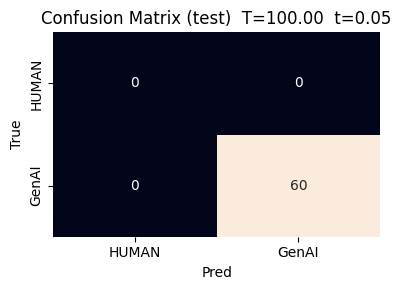

In [ ]:
#Pesi di classe (se dataset sbilanciato). Calcolati sul TRAIN.
cnt = Counter(train_ds.labels)
tot = len(train_ds)
imbalance = abs(cnt.get(0,0) - cnt.get(1,0)) / max(1, tot)

if imbalance < 0.05:
    print("[LOG] Dataset bilanciato → niente class weights")
    #CE standard con label smoothing.
    loss_fn = nn.CrossEntropyLoss(label_smoothing=global_var["label_smoothing"])
else:
    print("[LOG] Dataset train sbilanciato → uso class weights")
    w0 = tot / cnt.get(0,1)
    w1 = tot / cnt.get(1,1)
    w = torch.tensor([w0, w1], dtype=torch.float, device=device)
    loss_fn = nn.CrossEntropyLoss(weight=w, label_smoothing=global_var["label_smoothing"])

#Ottimizzatore Adam (L2 "coupled" via weight_decay).
optimizer = torch.optim.Adam(model.parameters(),
                             lr=global_var["learning_rate"],
                             weight_decay=global_var["weight_decay"])

#Scheduler: riduce il LR quando la val_loss "platea" (non migliora).
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

def train_amp(model, train_loader, val_loader, epochs, patience=4):
    """
    Usa:
      - loss_fn, optimizer, scheduler già definiti nella cella sopra (class weights, wd, ReduceLROnPlateau)
      - AMP per velocizzare su GPU
      - dynamic padding (viene dal DataLoader)
      - early stopping con 'patience'
    """
    #GradScaler per stabilizzare fp16 (abilitato solo su CUDA).
    scaler = torch.amp.GradScaler('cuda', enabled=(device.type=="cuda"))

    history = {"train": [], "val": []}    #Tracciamento delle loss per epoca.
    best_val = math.inf                   #Miglior val_loss osservata (per early stopping).
    best_state = None                     #Stato del modello corrispondente alla miglior val.
    bad = 0                               #Conteggio epoche senza miglioramento significativo.

    try:
        import torch as _t
        if hasattr(_t, "compile"):
            model = _t.compile(model)
    except Exception:
        pass


    for ep in range(epochs):
        # TRAIN:
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, unit="batch", desc=f"Epoch {ep+1}/{epochs} [train]")
        for bx, by in pbar:
            #Trasferimento su device con copie non bloccanti (richiede pin_memory=True nel DataLoader).
            bx = bx.to(device, non_blocking=True)
            by = by.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)   #Azzeramento gradienti (set None = più efficiente).

            #Autocast: precisione mista (fp16/fp32) in forward e loss su CUDA.
            with torch.amp.autocast('cuda', enabled=(device.type=="cuda")):
                logits = model(bx)                  #Forward --> logits [B, K].
                loss = loss_fn(logits, by)          #CE (con smoothing, e pesi se attivi).

            #Backward in fp16 scalato --> unscale --> clip --> step.
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     #Clipping L2 dei gradienti.
            scaler.step(optimizer)                                      #Applica l'aggiornamento dei pesi (scalato).
            scaler.update()                                             #Aggiorna il fattore di scala per fp16.

            running += loss.item()                                      #Accumula la loss media mostrata nella barra di progresso.
            pbar.set_postfix(loss=running/(pbar.n+1))

        # VALIDATION:
        model.eval()
        val_loss = 0.0
        #Inference_mode: no grad & no autograd bookkeeping; autocast per allineare precisione.
        with torch.inference_mode(), torch.amp.autocast('cuda', enabled=(device.type=="cuda")):
            for bx, by in val_loader:
                bx = bx.to(device, non_blocking=True)
                by = by.to(device, non_blocking=True)
                val_loss += loss_fn(model(bx), by).item()
        val_loss /= max(1, len(val_loader))

        #Log e storia.
        history["train"].append(running/max(1, len(train_loader)))
        history["val"].append(val_loss)
        print(f"[LOG] Ep{ep+1}: train={history['train'][-1]:.7f} | val={val_loss:.7f}")

        #Scheduler pilotato dalla val_loss (ReduceLROnPlateau).
        scheduler.step(val_loss)

        # EARLY STOPPING:
        #Miglioramento "significativo" se supera un delta minimo (1e-4).
        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())    #Salva i pesi migliori.
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(f"[LOG] Early stop a epoca {ep+1} (best val={best_val:.7f}).")
                break

    #Ripristina i pesi migliori (se esistono) prima di restituire la storia.
    if best_state is not None:
        model.load_state_dict(best_state)
    return history

# --- TRAINING come già hai (usa train_loader/val_loader di cui sopra) ---
history = train_amp(model, train_loader, val_loader,
                    epochs=global_var["epochs"],
                    patience=global_var["patience"])

# --- Calibrazione su VAL + tuning soglia su VAL ---
T = calibrate_temperature(model, val_loader, device)
t_star = tune_threshold_on_val(model, val_loader, device,
                               temperature=T, metric="balanced_accuracy")

# --- Valutazione FINALE su TEST (SOLO le 60 righe) ---
evaluate_on_test_with_threshold(model, test_loader, device, t_star, temperature=T)

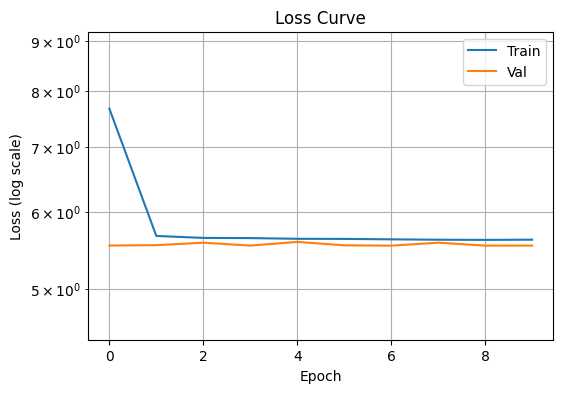

In [ ]:
# Adatta il plot all'ordine di grandezza
eps = 1e-12
_tr = np.clip(np.asarray(history["train"], dtype=float), eps, None)
_va = np.clip(np.asarray(history["val"],   dtype=float), eps, None)

plt.figure(figsize=(6,4))                                #Crea una nuova figura 6x4 pollici.
plt.plot(_tr, label="Train")                             #Curva loss di training.
plt.plot(_va, label="Val")                               #Curva loss di validazione.
plt.yscale("log")                                        #Scala logaritmica sull'asse Y.

#Limiti Y adattivi (margine 20%) per visualizzare bene valori molto piccoli.
ymin = min(_tr.min(), _va.min()) * 0.8
ymax = max(_tr.max(), _va.max()) * 1.2
plt.ylim(ymin, ymax)

plt.xlabel("Epoch"); plt.ylabel("Loss (log scale)");     #Etichette assi.
plt.title("Loss Curve")                                  #Titolo.
plt.legend(); plt.grid(True, which="both");              #Legenda e griglia.
plt.show()                                               #Renderizza il grafico.

In [ ]:
# --- Calibrazione SOLO su validation ---
def calibrate_temperature(model, val_loader, device):
    model.eval()
    logits_list, labels_list = [], []
    with torch.inference_mode():
        for bx, by in val_loader:
            logits_list.append(model(bx.to(device)))
            labels_list.append(by.to(device))
    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    nll  = torch.nn.CrossEntropyLoss()
    logT = torch.tensor(0.0, device=device, requires_grad=True)
    opt  = torch.optim.LBFGS([logT], lr=0.5, max_iter=50)

    def closure():
        opt.zero_grad()
        T = torch.exp(logT).clamp(1e-2, 100.0)   # clamp per stabilità
        loss = nll(logits / T, labels)
        loss.backward()
        return loss

    opt.step(closure)
    T = float(torch.exp(logT).clamp(1e-2, 100.0).item())
    print(f"[VAL] temperatura ottima T={T:.3f}")
    return T

def tune_threshold_on_val_safe(model, val_loader, device, temperature=1.0, metric="balanced_accuracy"):
    model.eval(); y_true, y_prob = [], []
    with torch.inference_mode():
        for bx, by in val_loader:
            p1 = F.softmax(model(bx.to(device)) / temperature, dim=1)[:, 1].cpu().numpy()
            y_prob.extend(p1); y_true.extend(by.numpy())
    y_true = np.array(y_true); y_prob = np.array(y_prob)

    # se mono-classe in validation, soglia standard
    if np.unique(y_true).size < 2:
        print("[VAL] mono-classe → uso soglia 0.50")
        return 0.50

    grid = np.linspace(0.05, 0.95, 19)
    best_t, best_s = 0.5, -1
    for t in grid:
        y_hat = (y_prob >= t).astype(int)
        s = balanced_accuracy_score(y_true, y_hat) if metric=="balanced_accuracy" \
            else f1_score(y_true, y_hat, average="macro")
        if s > best_s: best_s, best_t = s, t
    print(f"[VAL] soglia ottima t*={best_t:.2f}")
    return float(best_t)

# usa SOLO val_loader:
T = calibrate_temperature(model, val_loader, device)
t_star = tune_threshold_on_val_safe(model, val_loader, device, temperature=T, metric="balanced_accuracy")

[VAL] temperatura ottima T=100.000
[VAL] mono-classe → uso soglia 0.50


# Quick predition

Questo blocco fa tre cose:

1. **Imposta** il percorso base su Drive e lo **crea** se manca.
2. Definisce un **alias di sicurezza** per `val_loader` (se non esiste, usa `test_loader`, così le utility di calibrazione non falliscono).
3. Implementa un **recupero resiliente** del vocabolario usato nel training (`base_vocab`), risalendo **ricorsivamente** attraverso container tipici di PyTorch (es. `Subset`, `DataLoader --> .dataset --> …`) finché trova un attributo `vocab`. Se non lo trova:
   - prova vari **candidati globali** in ordine di probabilità;
   - usa `vocab` **globale** se presente;
   - come **ultimo fallback** lo **ricostruisce** da `TRAIN_CSV` (non ideale perché potrebbe includere righe non usate dopo lo split).


**Complessità:** tempo $\mathcal{O}(\text{profondità della catena})$, memoria $\mathcal{O}(1)$.

In [ ]:
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"        #Percorso base di lavoro su Google Drive.
os.makedirs(BASE, exist_ok=True)                                #Crea la directory se non esiste (idempotente).

#Se non è stato definito val_loader nel notebook, usa il test_loader come validation.
try:
    val_loader                                                 #Prova ad accedere al nome: se non esiste lancia NameError.
except NameError:
    val_loader = test_loader                                   #Fallback sicuro: evita crash nelle funzioni che richiedono VAL.

def extract_vocab(obj):
    """
    Restituisce obj.vocab se esiste; se obj è un Subset o un DataLoader,
    scende ricorsivamente in .dataset finché trova 'vocab'.
    """
    seen = set()                                               #Set di id() per evitare cicli (es. riferimenti ricorsivi).
    while obj is not None and id(obj) not in seen:             #Cammina finché c'è un oggetto nuovo nella catena.
        seen.add(id(obj))                                      #Marca l'oggetto corrente come visitato.
        if hasattr(obj, "vocab"):                              #Caso base: l'oggetto espone direttamente il vocabolario.
            return obj.vocab
        obj = getattr(obj, "dataset", None)                    #Altrimenti scendi in .dataset (Subset/DataLoader/...).
    return None                                                #Se non trovato, segnala fallimento.

#Prova a prendere il vocab da sorgenti note (in ordine di probabilità).
base_vocab = None
for cand in [
    globals().get("train_dataset", None),             #Può essere Subset --> ha .dataset interno.
    globals().get("full_train", None),                #Istanza completa del dataset di train.
    globals().get("train_ds", None),                  #Eventuale alias usato altrove.
    globals().get("train_loader", None),              #DataLoader: si scende in .dataset.
]:
    base_vocab = extract_vocab(cand)                  #Tenta l'estrazione ricorsiva.
    if base_vocab is not None:
        break                                         #Appena trovato, interrompi la ricerca.

#Fallback: usa 'vocab' globale se esiste.
if base_vocab is None and "vocab" in globals():
    base_vocab = vocab                                #Riutilizza il mapping già in memoria.

#Ultimo fallback: ricostruisce dal TRAIN_CSV (non ideale ma funziona)
if base_vocab is None and "TRAIN_CSV" in globals():
    print("[WARN] Non trovo il vocab del training; lo ricostruisco dal TRAIN_CSV (non ideale).")
    base_vocab = TextDataset(TRAIN_CSV).vocab         #Ricostruzione completa.

if base_vocab is None:
    raise RuntimeError(
        "Impossibile recuperare il vocabolario del training. "
        "Assicurati che 'train_dataset' (o 'train_loader') sia in memoria, "
        "oppure definisci una variabile globale 'vocab' con il mapping token→id."
    )

print(f"[LOG] Vocab recuperato correttamente (size={len(base_vocab):,}).")  #Esito positivo con dimensione formattata.

[LOG] Vocab recuperato correttamente (size=45,509).


Queste utility valutano il classificatore su un **DataLoader** o direttamente da **CSV** (con **dynamic padding**).  
Con logits $z\in\mathbb{R}^{B\times K}$ e temperatura $T>0$, le probabilità sono:
$$
p=\mathrm{softmax}\!\left(\frac{z}{T}\right),\qquad
p_{i,c}=\frac{e^{z_{i,c}/T}}{\sum_{j} e^{z_{i,j}/T}}.
$$

**Decisione:**
- senza soglia: $\;\hat y_i=\arg\max\limits_{c}\; z_{i,c}$  
- con soglia $t$ (binaria, classe 1): $\;\hat y_i=\mathbf{1}[\,p_{i,1}\ge t\,]$

Si computano il **classification report** (precision/recall/F1 per classe e aggregati) e la **confusion matrix**; facoltativamente si visualizza la **heatmap**.  
`evaluate_csv` costruisce un `TextDataset` da `csv_path`, crea il `DataLoader` con `make_loader` (--> *dynamic padding*) e richiama `evaluate_loader`.

In [ ]:
def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    model.eval()                                           #Modalità valutazione: disabilita dropout/batchnorm.
    y_true, y_pred = [], []                                #Accumulatori: etichette vere e predette.

    with torch.inference_mode():                           #No autograd per efficienza/memoria.
        for bx, by in loader:
            #Forward con eventuale temperature scaling (T=1 --> invariato).
            logits = model(bx.to(device)) / temperature

            if threshold is None:
                #Multiclasse standard: predizione = argmax dei logits.
                pred = logits.argmax(1).cpu().numpy()
            else:
                #Binaria con soglia: usa p(classe=1) e confronta con t.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)

            #Accumula predizioni e label (su CPU/numpy).
            y_pred.extend(pred)
            y_true.extend(by.cpu().numpy().tolist())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Determine the set of unique labels present in both true and predicted labels
    all_labels = np.unique(np.concatenate((y_true, y_pred)))
    # Ensure labels are sorted for consistent ordering
    all_labels.sort()

    # Map integer labels to names for target_names
    current_target_names = [label_names[i] for i in all_labels]


    # REPORT DETTAGLIATO (dict) CON METRICHE PER CLASSE E MACRO/MICRO/WEIGHTED:
    report = classification_report(
        y_true, y_pred,
        target_names=current_target_names,
        labels=all_labels,
        output_dict=True,
        digits=4,
        zero_division='warn' # or '0' or 'nan' depending on desired behavior for zero division
    )

    # CONFUSION MATRIX (righe = True, colonne = Pred).
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)

    if plot_cm:
        #Heatmap della confusion matrix con etichette leggibili.
        plt.figure(figsize=(5, 4))
        # Use the determined target names for tick labels
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=current_target_names, yticklabels=current_target_names)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm


def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    #Dimensione batch di default dalla config globale.
    batch_size = batch_size or global_var["batch_size"]

    #Costruisce dataset dal CSV riusando il vocabolario del training.
    ds = TextDataset(csv_path, vocab=vocab)

    #DataLoader con dynamic padding via collate_trim (make_loader gestisce n_workers/pin_memory).
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)

    #Valuta come sopra (stesse opzioni di temperature/soglia/plot).
    rep, cm = evaluate_loader(
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )

    #Restituisce anche la dimensione del dataset per completezza.
    return rep, cm, len(ds)

Questo blocco crea un **mini–dataset di evaluation** (30 righe bilanciate per *topic* e *classe*: $0=\text{HUMAN}$, $1=\text{GenAI}$), lo **salva** in CSV, mostra una **diagnostica rapida** delle distribuzioni, poi esegue la **calibrazione** delle probabilità via *temperature scaling* (stima di $T>0$ su validation), il **tuning** di una **soglia di decisione** $t^*$ su validation (massimizzando *balanced accuracy* o *macro–F1*), e infine la **valutazione completa** sul CSV appena creato (con **confusion matrix** in heatmap e **metriche macro**).

Formalmente, date le logit $z\in\mathbb{R}^K$, si calibra:
$$
p_c(T)=\frac{e^{z_c/T}}{\sum_{j=1}^{K} e^{z_j/T}},
$$

e in binario si decide:
$$
\hat y=\mathbf{1}\!\left[p_1(T)\ge t^*\right].
$$

La scelta di $T$ **minimizza** la NLL su validation; $t^*$ **massimizza** la metrica scelta su validation.  
Il report finale mostra **Accuracy**, **F1 macro**, **Precision macro** e **Recall macro**.

[LOG] VALIDATION/EVAL: /content/drive/MyDrive/TESI-Classificazione/MIO/it_val_holdout.csv  (1783 righe)
[LOG] Distribuzione label:
label
1    1783
[VAL] temperatura ottima T=100.000
[VAL] soglia ottima t*=0.05 (bal_acc=1.000, f1_macro=1.000, acc=1.000)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use th

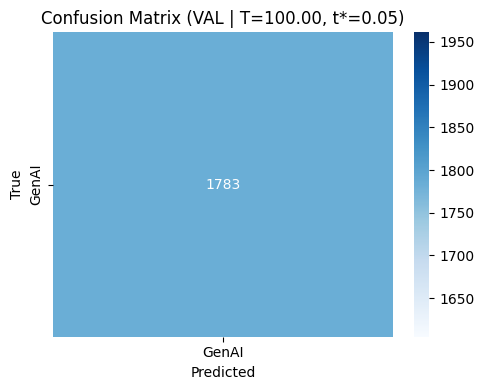


[LOG] Evaluation su VALIDATION — campioni: 1783
Accuracy: 1.0000  |  F1 macro: 1.0000  |  Precision macro: 1.0000  |  Recall macro: 1.0000


In [ ]:
# ================== VALIDATION (alias EVAL) ==================
# Usa ESATTAMENTE il file creato nel blocco HOLDOUT:
assert 'VAL_CSV' in globals(), "VAL_CSV non definito: esegui prima il blocco HOLDOUT."
assert os.path.exists(VAL_CSV), f"File non trovato: {VAL_CSV}"

# Verifica rapida distribuzione
df_eval = pd.read_csv(VAL_CSV)
print(f"[LOG] VALIDATION/EVAL: {VAL_CSV}  ({len(df_eval)} righe)")
print("[LOG] Distribuzione label:")
print(df_eval["label"].value_counts().sort_index().to_string())

# ========== Calibrazione temperatura e tuning soglia SU VALIDATION ==========
# (usa sempre val_loader; evita variabili duplicate tipo T_eval/t_eval)
T = calibrate_temperature(model, val_loader, device)
t_star = tune_threshold_on_val(
    model, val_loader, device, temperature=T, metric="balanced_accuracy"
)

# ========== Valutazione su VALIDATION (stesso file EVAL_CSV) ==========
# If evaluate_csv is not already defined globally, define it here.
# This seems to be the case in the current notebook state.
if 'evaluate_csv' not in globals() or not callable(evaluate_csv):
    def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                     label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                     plot_cm=False, title_suffix=""):
        batch_size = batch_size or global_var["batch_size"]
        ds = TextDataset(csv_path, vocab=vocab)
        dl = make_loader(ds, batch_size=batch_size, shuffle=False)

        model.eval()
        y_true, y_pred = [], []
        with torch.inference_mode():
            for bx, by in dl:
                logits = model(bx.to(device)) / temperature
                if threshold is None:
                    pred = logits.argmax(1).cpu().numpy()
                else:
                    p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                    pred = (p1 >= threshold).astype(int)
                y_pred.extend(pred)
                y_true.extend(by.cpu().numpy())

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Determine the set of unique labels present in both true and predicted labels
        all_labels = np.unique(np.concatenate((y_true, y_pred)))
        # Ensure labels are sorted for consistent ordering
        all_labels.sort()

        # Map integer labels to names for target_names
        current_target_names = [label_names[i] for i in all_labels]

        # Use the combined unique labels for classification_report and confusion_matrix
        report = classification_report(
            y_true, y_pred,
            target_names=current_target_names,
            labels=all_labels,
            output_dict=True,
            digits=4,
            zero_division='warn' # or '0' or 'nan' depending on desired behavior for zero division
        )

        cm = confusion_matrix(y_true, y_pred, labels=all_labels)


        if plot_cm:
            plt.figure(figsize=(5,4))
            # Use the determined target names for tick labels
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=current_target_names, yticklabels=current_target_names)
            ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
            plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
            plt.tight_layout(); plt.show()

        return report, cm, len(ds)

# Esegui la valutazione su VALIDATION con T e t* trovati su validation
rep_eval, cm_eval, n_eval = evaluate_csv(
    model, VAL_CSV, vocab=vocab,                     # riusa il vocab del TRAIN
    label_names=("HUMAN","GenAI"),
    temperature=T, threshold=t_star,
    plot_cm=True, title_suffix=f"(VAL | T={T:.2f}, t*={t_star:.2f})"
)

# Report compatto
assert cm_eval.sum() == n_eval, f"Non ho visto tutto l'EVAL: visti {cm_eval.sum()} su {n_eval}"
print(f"\n[LOG] Evaluation su VALIDATION — campioni: {n_eval}")
if 'macro avg' in rep_eval:
    print(f"Accuracy: {rep_eval['accuracy']:.4f}  |  F1 macro: {rep_eval['macro avg']['f1-score']:.4f}  "
          f"|  Precision macro: {rep_eval['macro avg']['precision']:.4f}  |  Recall macro: {rep_eval['macro avg']['recall']:.4f}")
else:
    # case with potentially only one class reported (if macro avg is not present)
    # Attempt to find the metrics for the existing class(es)
    metrics_output = ""
    for label_int, label_name in enumerate(label_names):
        if str(label_int) in rep_eval:
             metrics_output += (f"F1 ({label_name}): {rep_eval[str(label_int)]['f1-score']:.4f}  "
                               f"|  Precision ({label_name}): {rep_eval[str(label_int)]['precision']:.4f}  "
                               f"|  Recall ({label_name}): {rep_eval[str(label_int)]['recall']:.4f}")
             # Add space if there are more classes to report
             if len(all_labels) > 1 and label_int == all_labels[0] and len(all_labels) > 1:
                 metrics_output += "  |  "

    print(f"Accuracy: {rep_eval['accuracy']:.4f}  |  {metrics_output if metrics_output else '(Metriche per singola classe non disponibili)'}")

Questo blocco costruisce un **tabellone di evaluation**: legge il CSV creato in precedenza, esegue **inference** con *temperature scaling* $T_{\text{eval}}$ e **soglia** $t_{\text{eval}}$, aggrega **probabilità**, **predizioni**, **etichette vere**, e produce una **tabella ordinata** (errori in alto) oltre a salvare un CSV completo su Drive.

- **Rilevamento BASE:** se la variabile non esiste, prova due path noti su Drive e prende il primo che trova.
- **Caricamento eval:** `TextDataset(EVAL_CSV, vocab=full_train.vocab)` garantisce che gli ID token siano **coerenti** con il training.
- **Inference:** per ogni batch, calcola
$$
p_{1}=\big(\mathrm{softmax}(z/T_{\text{eval}})\big)_{c=1},
\qquad
\hat y=\mathbf{1}\!\left[p_{1}\ge t_{\text{eval}}\right],
$$
  dove $p_{1}$ è la probabilità della classe *GenAI*.
- **Output tabellare:** costruisce un `DataFrame` con colonne testuali e numeriche, mappa gli ID a stringhe (*HUMAN/GenAI*), aggiunge un flag **✓/✗** e **ordina** portando in testa gli errori.
- **Visualizzazione & salvataggio:** mostra a schermo le **prime 30 righe** e salva **tutto** in un CSV versionato con $T_{\text{eval}}$ e $t_{\text{eval}}$ nel nome. Un secondo riquadro opzionale mostra **solo gli errori**.

              precision    recall  f1-score   support

           1      1.000     1.000     1.000        60

    accuracy                          1.000        60
   macro avg      1.000     1.000     1.000        60
weighted avg      1.000     1.000     1.000        60



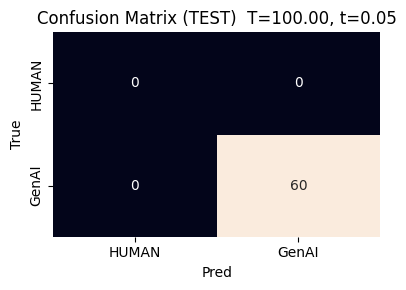

[INFO] Mostro le prime 30 righe (errori in alto). Il file completo viene salvato su Drive.



,id,text,true,pred,prob_genai,correct
28,2c66a4b1-508e-4158-818d-c03e62cc6bc2,"Kabul - Doppio attentato alle truppe italiane nell'arco di poche ore. Un ordigno è esploso, la scorsa notte, al passaggio di un mezzo militare italiano vici...",GenAI,GenAI,0.488759,✓
46,fbd9f376-e7cc-476e-ab23-74bf3bd5900c,"Sto bene"" è una frase che spesso viene usata per rassicurare gli altri quando si sta attraversando un momento difficile. Tuttavia, questa semplice affermazi...",GenAI,GenAI,0.488679,✓
55,c8ec684a-0750-43fd-89fa-b4f9dc3d4437,"di Bruno Silini Basta conoscerla per cinque minuti per lasciarsi contagiare dalla sua vitalità, dalla pressoché inesauribile spinta propositiva che la contr...",GenAI,GenAI,0.488652,✓
2,ad0203ec-4722-4604-8a2f-af5157fe8e0f,Il Presidente Obama ha recentemente annunciato che le scuole pubbliche saranno ora valutate e premiate in base ai risultati degli studenti. Questa nuova pol...,GenAI,GenAI,0.488632,✓
39,503563a0-8950-497a-90c0-4ac73e8641b8,"Michelle Hunziker e la figlia Aurora Ramazzotti sono più unite che mai, il loro rapporto è davvero invidiabile, ma come è nella sfera privata la showgirl sv...",GenAI,GenAI,0.488595,✓
16,f7474a70-8266-4dd2-83be-fafb3e6df219,La Relazione 2016 al Parlamento fotografa l'attività dei servizi riguardo ai settori di competenza. L'Aise (sicurezza esterna) ha lavorato principalmente su...,GenAI,GenAI,0.488584,✓
31,88a90536-ac25-4b6c-92cc-2f1e6c059e18,"Una piccola fiaba di Natale quella che ha coinvolto un delicato cagnolino di razza Shih Tzu, abbandonato proprio la vigilia di Natale. Il minuscolo esserino...",GenAI,GenAI,0.488567,✓
57,a01f9e88-0bd6-4979-b726-3cacb4754271,"Chiara Ferragni e Fedez si sposano. E ora gli occhi dei media e non solo saranno puntati su di loro, per cercare di scoprire ogni minimo dettaglio, dal mode...",GenAI,GenAI,0.488559,✓
22,82481833-d670-49d0-8718-af987ff89762,"Palermo - In questi giorni, dopo i 51 arresti, a Palermo sarà un po' più caotico conseguire la patente. Ma almeno sarà tutto regolare, o così si spera. Nell...",GenAI,GenAI,0.488528,✓
35,df47eab3-e583-49c5-935e-e6c18d1bcfc7,Il perito tecnico Marco Galiazzo ha una sola certezza: se dovesse rivincere la medaglia doro alle Olimpiadi di Pechino non cambierebbe la sua Seat. «Perché...,GenAI,GenAI,0.488515,✓


[LOG] File completo salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/predictions_TEST_fixed_T100.00_t0.05.csv

[INFO] Errori totali: 0



,id,text,true,pred,prob_genai,correct


In [ ]:
# ===== D) Predizione/Report SOLO su TEST fissato (60 righe) =====
# Richiede: BASE, vocab, model, device, global_var, T, t_star già definiti (T e t_star dalla VALIDATION)

# 1) Path TEST (accetta TEST_OUT o TEST_CSV creati nel Punto A)
TEST_CSV_PATH = locals().get("TEST_OUT", locals().get("TEST_CSV", f"{BASE}/it_test_fixed.csv"))
assert os.path.exists(TEST_CSV_PATH), f"File TEST non trovato: {TEST_CSV_PATH}"

# 2) DataLoader su TEST riusando il vocab del TRAIN
test_ds = TextDataset(TEST_CSV_PATH, vocab=vocab)
assert len(test_ds) == 60, f"Il TEST deve avere 60 righe, trovato {len(test_ds)}"
test_dl = make_loader(test_ds, batch_size=global_var["batch_size"], shuffle=False)

# 3) Inference su TEST con temperatura T e soglia t_star (entrambe da VALIDATION)
y_true, y_prob = [], []
model.eval()
with torch.inference_mode():
    for bx, by in test_loader:
        logits = model(bx.to(device)) / T
        p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        y_prob.extend(p1.tolist()); y_true.extend(by.cpu().numpy().tolist())

y_true = np.array(y_true, dtype=int)
y_pred = (np.array(y_prob) >= t_star).astype(int)

# 3) Metriche + Confusion Matrix 2x2
print(classification_report(y_true, y_pred, digits=3))
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cbar=False,
            xticklabels=["HUMAN","GenAI"], yticklabels=["HUMAN","GenAI"])
plt.xlabel("Pred"); plt.ylabel("True"); plt.title(f"Confusion Matrix (TEST)  T={T:.2f}, t={t_star:.2f}")
plt.tight_layout(); plt.show()

# 4) Tabella predizioni ordinata (errori in alto) + salvataggio
df_src = pd.read_csv(TEST_CSV_PATH)
map_lab = {0:"HUMAN", 1:"GenAI"}
df_out = pd.DataFrame({
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),
    "true_id": y_true,
    "pred_id": y_pred,
    "prob_genai": np.array(y_prob, dtype=float)
})
df_out["true"] = df_out["true_id"].map(map_lab)
df_out["pred"] = df_out["pred_id"].map(map_lab)
df_out["correct"] = np.where(df_out["true_id"] == df_out["pred_id"], "✓", "✗")

df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"] == "✓").astype(int)
df_view = df_view.sort_values(["err_rank","prob_genai"], ascending=[True, False]).drop(columns=["err_rank"])

pd.set_option("display.max_colwidth", 160)
display_cols = [c for c in ["id","topic"] if c in df_view.columns] + ["text","true","pred","prob_genai","correct"]
print("[INFO] Mostro le prime 30 righe (errori in alto). Il file completo viene salvato su Drive.\n")
display(df_view[display_cols].head(30))

fname = f"predictions_TEST_fixed_T{T:.2f}_t{t_star:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] File completo salvato in:", save_path)

# (facoltativo) Solo errori
df_errors = df_view[df_view["correct"]=="✗"][display_cols]
print(f"\n[INFO] Errori totali: {len(df_errors)}\n")
display(df_errors.head(20))